# Подготовка прототипа модели для металлообрабатывающего предприятия 

В нашем распоряжении данные с параметрами добычи и очистки. Задача - разработка модели, предсказывающей коэффициент восстановления золота из золотосодержащей руды. Данная модель поможет оптимизировать производство и позволит не запускать предприятие с убыточными характеристиками. Проверим финальную модель на адекватность - сравним с константной моделью.

### План решения задачи

* [1. Подготовка данных](#1-bullet)
* [2. Анализ данных](#2-bullet)
* [3. Подбор модели и вывод](#3-bullet)

# 1. Подготовка данных <a id='1-bullet'></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# переназначим индексы для более эффективной интерполяции по дате

train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col='date', parse_dates=['date'])
test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col='date', parse_dates=['date'])
full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col='date', parse_dates=['date'])

print(train.shape)
print(test.shape)
print(full.shape)

(16860, 86)
(5856, 52)
(22716, 86)


В тесте заметно меньше фичей чем в трейне - посмотрим чего не хватает

In [3]:
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, т.к. их невозможно получить/измерить во время выполнения технологического процесса.

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery

Эффективность обогащения рассчитывается по формуле:

\begin{align}
{Recovery} = \frac{C\times(F-T)}{F\times(C-T)}\times100\%
\end{align}

где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

In [4]:
print('Минимальное значение столбца:', train['rougher.output.recovery'].min())
print('Максимальное значение столбца:', train['rougher.output.recovery'].max())

Минимальное значение столбца: 0.0
Максимальное значение столбца: 100.0


In [5]:
def recovery(C, F, T):
    
    answer = ( (C * (F - T)) / (F * (C - T)) ) * 100
    
    answer[answer < 0] = np.nan      # заменим на nan все значения, которые выходят за уже посчитанный диапазон
    answer[answer > 100] = np.nan
    
    return answer

In [6]:
new_recovery_data = recovery(train['rougher.output.concentrate_au'],
                            train['rougher.input.feed_au'],
                            train['rougher.output.tail_au'])

In [7]:
# сравним новые значения со старыми, подсчитав MAE, предворительно заполнив пропуски нулями

mean_absolute_error(train['rougher.output.recovery'].interpolate(method='time'),
                    new_recovery_data.interpolate(method='time'))

9.35113328539498e-15

In [8]:
# значение ошибки маленькое, но для наглядности посчитаем разницу руками

print('Общее количество данных:', len(new_recovery_data))
print('Число несовпадающих значений:', 
      len(new_recovery_data) - np.isclose(train['rougher.output.recovery'], new_recovery_data).sum())

Общее количество данных: 16860
Число несовпадающих значений: 2573


Несовпадающих значений действительно немного - делаем вывод, что признак recovery был посчитан верно. Перед тем как перейти к анализу данных уберем лишние столбцы из train, приведя train и test к одному виду.

#### Технологический процесс состоит из двух независимых этапов: флотация и очистка

Всвязи с чем возникает необходимость разделить датасет на две части со своими фичами и целевыми признаками

In [9]:
X_train = train[test.columns]

In [10]:
# флотация

rougher_data = X_train.columns.str.contains('rougher')
X_train_rougher = X_train.loc[:, rougher_data]
X_test_rougher = test.loc[:, rougher_data]
y_train_rougher = train[['rougher.output.tail_au', 'rougher.output.concentrate_au']]

In [11]:
# очистка

cleaner_data = X_train.columns.str.contains('cleaner')
X_train_cleaner = X_train.loc[:, cleaner_data]
X_test_cleaner = test.loc[:, cleaner_data]
y_train_cleaner = train[['final.output.tail_au', 'final.output.concentrate_au']]

In [12]:
X_train_rougher.shape, X_test_rougher.shape, y_train_rougher.shape

((16860, 22), (5856, 22), (16860, 2))

In [13]:
X_train_cleaner.shape, X_test_cleaner.shape, y_train_cleaner.shape

((16860, 30), (5856, 30), (16860, 2))

# 2. Анализ данных <a id='2-bullet'></a>

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

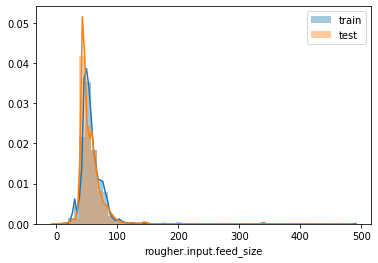

In [15]:
sns.distplot(train['rougher.input.feed_size'].dropna(), label='train')
sns.distplot(test['rougher.input.feed_size'].dropna(), label='test')
plt.legend()

Распределения размеров на обучающей и тестовой выборке похожи, а значит оценка модели должна оказаться правильной. Как я понимаю, видоизменять тестовую выборку мы не можем для чистоты эксперемента. Если же мы уберем выбросы только по трейну, то мы лишимся схожести в распределении, из-за чего можем потерять в качестве. Ради интереса я убрал выбросы на обоих выборках и качество итоговой метрики улучшилось лишь на несколько сотых пункта. Если же убирать "хвост" только по трейну, то ее значения, ожидаемо, становятся немного хуже. Поэтому я принял решение ничего не менять в итоговом варианте

### Посмотрим как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

In [16]:
metals = ['au', 'ag', 'pb']     # будем подставлять в конец наименования признака

stages = ['rougher.input.feed', 'rougher.output.concentrate',
           'primary_cleaner.output.concentrate', 'final.output.concentrate']    # процессы

stages_tail = ['rougher.input.feed', 'rougher.output.tail',
                'primary_cleaner.output.tail', 'final.output.tail']    # хвосты

sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (20, 6), 
        "axes.titlesize": 18,
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 6

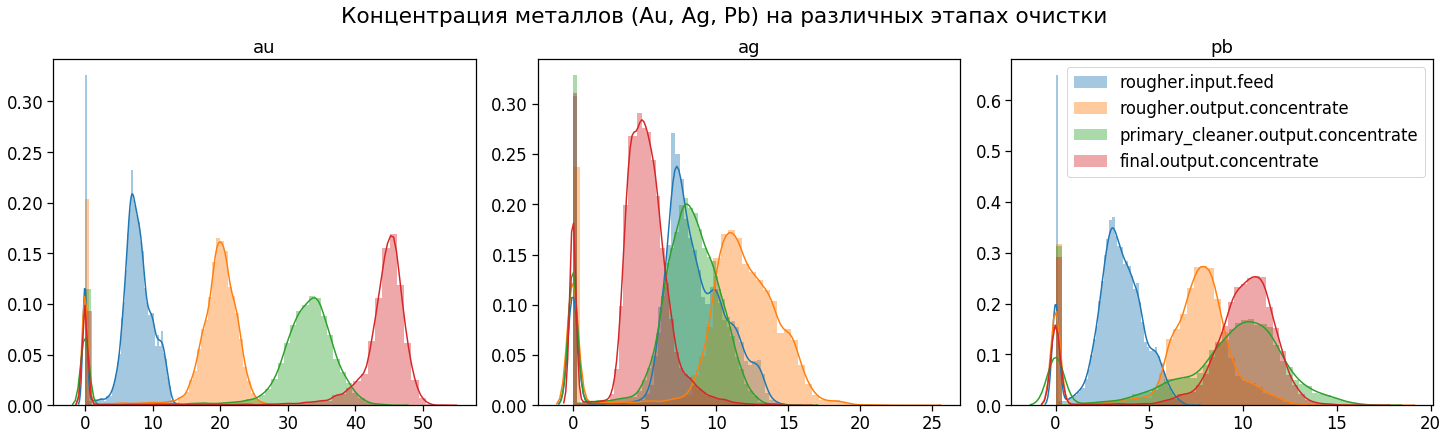

In [17]:
fig, axs = plt.subplots(1, len(metals), constrained_layout=True)
fig.suptitle('Концентрация металлов (Au, Ag, Pb) на различных этапах очистки')

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in stages:
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

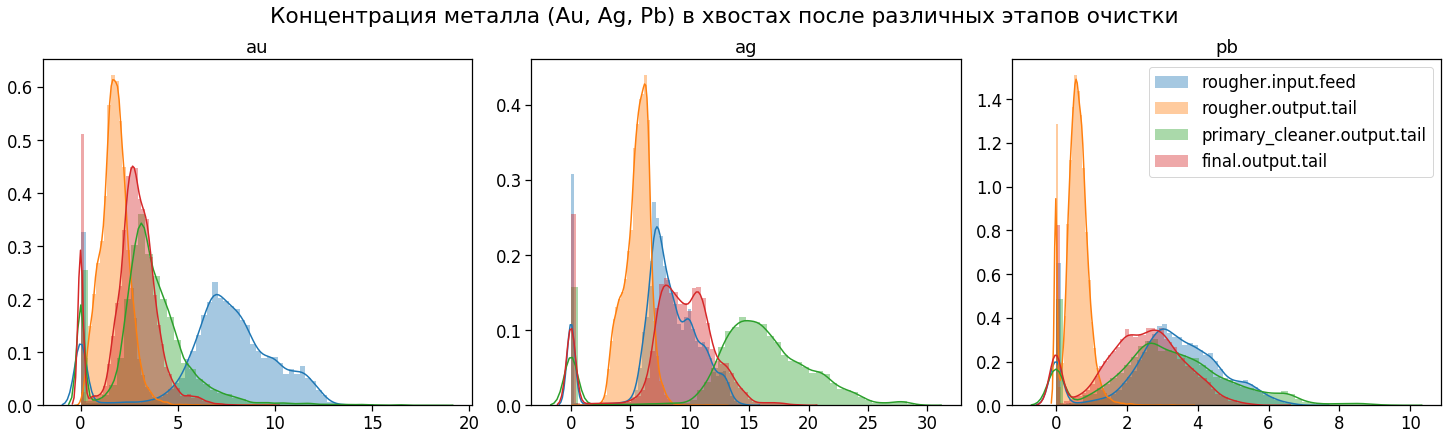

In [18]:
fig, axs = plt.subplots(1, len(metals), constrained_layout=True)
fig.suptitle('Концентрация металла (Au, Ag, Pb) в хвостах после различных этапов очистки')

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in stages_tail:
        cols = train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

Концентрация золота возрастает после каждого этапа очистки. Аналогичная ситуация наблюдается и по другим металлам, однако динамика выражена не так ярко как по золоту. Стоит отметить, что наибольшая концентрация металлов наблюдается после флотации, тогда как после "очистки" она становится несколько меньше. 

### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. По обеим выборкам

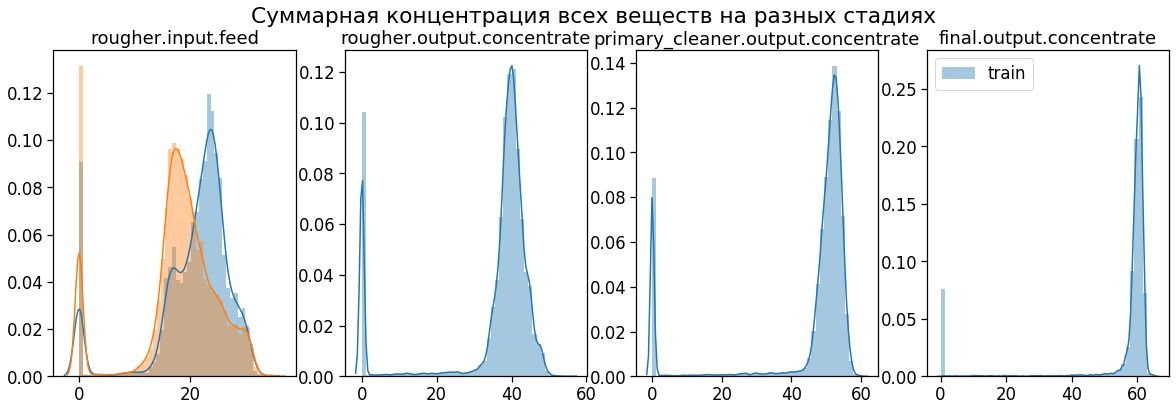

In [233]:
fig, axs = plt.subplots(1, len(process))
fig.suptitle('Суммарная концентрация всех веществ на разных стадиях')

for stage, ax in zip(stages, axs):
    ax.set_title(stage)
    sum_train = train[stage+ '_ag'] + train[stage+ '_au'] + train[stage+ '_pb']
    try:
        sum_test = test[stage+ '_ag'] + test[stage+ '_au'] + test[stage+ '_pb']
        sns.distplot(sum_test.dropna(), label='test', ax=ax) 
    except KeyError:
        pass
    sns.distplot(sum_train.dropna(), label='train', ax=ax) 

plt.legend()
plt.show()

Присутствуют выбросы, но вряд ли стоит считать их аномалиями, так как, судя по всему, они являются частью производственного процесса. Наша цель - предсказывать значения на реальных данных, а эти выбросы и есть реальная концентрация - модель должна уметь их видеть и обрабатывать. 

# 3. Подбор модели и вывод <a id='3-bullet'></a>

**Метрика качества**
Для решения задачи будем использовать — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Она симметричная, так как одинаково учитывает масштаб и целевого признака, и предсказания.


\begin{align}
{sMAPE} = \frac{1}{N} \sum_{i=1}^{N}\frac{|y_i-\hat{y_i}|}{(|y_i|+|\hat{y_i}|)/2}\times100\%
\end{align}

Нужно спрогнозировать сразу две величины:
* эффективность обогащения чернового концентрата rougher.output.recovery;
* эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:

\begin{align}
{Итоговое sMAPE} = 25\% \times sMAPE(rougher) + 75\% \times sMAPE(final)
\end{align}


           


Для sMAPE лучший результат тот, что меньше. Поэтому в рамках использования GridSearchCV и sMAPE, для make_scorer нужно указать **greater_is_better=False**, тогда sMAPE будет считаться с отрицательным знаком, но по модулю значения будут положительными. Соответственно GridSearch будет максимизировать sMAPE, по модулю выдавая наименьшее значение, т.е. самое лучшее.

In [14]:
def sMAPE(y_true, y_pred, multioutput='uniform_average'):
    
    numerator = np.abs(y_true-y_pred)
    denominator = (np.abs(y_true)+np.abs(y_pred))/2
    
    division_result = np.divide(numerator, denominator)
    
    nonzero_denominator = denominator != 0   
    division_result[~nonzero_denominator] = 0
    
    final_result = np.average(division_result, axis=0)
    
    if multioutput == 'raw_values':
        return final_result
    elif multioutput == 'uniform_average':
        pass
    return np.average(final_result)


finalized_smape = make_scorer(sMAPE, greater_is_better=False)

In [15]:
# заполним пропуски в обучающем датасете

y_train_rougher = y_train_rougher.interpolate(method='time')
y_train_cleaner = y_train_cleaner.interpolate(method='time')  

In [16]:
# уберем нулевые значения в таргете

def drop_zeros(X, y):
    y = y[(y != 0).all(1)]  
    X = X.loc[y.index, :]
    return X, y

print('До обработки: ', X_train_rougher.shape, y_train_rougher.shape,
      X_train_cleaner.shape, y_train_cleaner.shape)

X_train_rougher, y_train_rougher = drop_zeros(X_train_rougher, y_train_rougher)
X_train_cleaner, y_train_cleaner = drop_zeros(X_train_cleaner, y_train_cleaner)

print('После обработки: ', X_train_rougher.shape, y_train_rougher.shape,
      X_train_cleaner.shape, y_train_cleaner.shape)

До обработки:  (16860, 22) (16860, 2) (16860, 30) (16860, 2)
После обработки:  (15313, 22) (15313, 2) (15038, 30) (15038, 2)


In [17]:
# нам предоставили данные за каждый час производства
# судя по всему, время имеет значение поэтому будет использовать TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=5)

# Зададим pipelane и param_grid для grid

rnd_state = 442

pipeline = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan)),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=rnd_state))
])

params = [
    {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [RandomForestRegressor(n_estimators=10, random_state=rnd_state)],
        'model__max_features': np.linspace(0.1, 1, 10)
    }, 
    {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [LinearRegression()]
    }, 
    {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [Ridge(random_state=rnd_state)],
        'model__alpha': np.logspace(-3, 1, 10)
    }, 
    {
        'imp__strategy': ['mean', 'median', 'most_frequent'],
        'model': [Lasso(random_state=rnd_state)],
        'model__alpha': np.logspace(-3, 1, 10)
    }
]

grid = GridSearchCV(pipeline, param_grid=params, cv=cv, scoring=finalized_smape, n_jobs=-1)

In [18]:
# флотация

grid.fit(X_train_rougher, y_train_rougher)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestRegressor(boo

In [19]:
grid.best_params_, grid.best_score_

({'imp__strategy': 'mean',
  'model': Lasso(alpha=0.021544346900318832, copy_X=True, fit_intercept=True,
        max_iter=1000, normalize=False, positive=False, precompute=False,
        random_state=442, selection='cyclic', tol=0.0001, warm_start=False),
  'model__alpha': 0.021544346900318832},
 -0.2772798859038759)

In [20]:
# сверим с константной моделью

from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_rougher, y_train_rougher)

dummy_prediction = dummy_regr.predict(X_train_rougher)

dummy_prediction.shape

(15313, 2)

In [22]:
sMAPE(y_train_rougher, dummy_prediction)

0.2583368316201964

In [21]:
# очистка

grid_clean = GridSearchCV(pipeline, param_grid=params, cv=cv, scoring=finalized_smape, n_jobs=-1)

grid_clean.fit(X_train_cleaner, y_train_cleaner)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imp',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestRegressor(boo

In [23]:
grid_clean.best_params_, grid_clean.best_score_

({'imp__strategy': 'mean',
  'model': Lasso(alpha=1.2915496650148828, copy_X=True, fit_intercept=True, max_iter=1000,
        normalize=False, positive=False, precompute=False, random_state=442,
        selection='cyclic', tol=0.0001, warm_start=False),
  'model__alpha': 1.2915496650148828},
 -0.17082305249236432)

In [24]:
dummy_regr_clean = DummyRegressor(strategy="mean")
dummy_regr_clean.fit(X_train_cleaner, y_train_cleaner)

dummy_prediction_clean = dummy_regr_clean.predict(X_train_cleaner)

sMAPE(y_train_cleaner, dummy_prediction_clean)

0.15954930763608344

In [242]:
# проверяем лучшие модели на тестовой выборке

test_data = test['rougher.input.feed_au'].fillna(0)

In [249]:
# grid - флотация

best_rougher = grid.best_estimator_

if type(best_rougher.steps[2][1]) is type(RandomForestRegressor()):    
    best_rougher.steps[2][1].n_estimators = 100
    
best_rougher.fit(X_train_rougher, y_train_rougher)

y_pred_rougher_tail, y_pred_rougher_conc = best_rougher.predict(X_test_rougher).T
rougher_recovery = recovery(y_pred_rougher_conc, test_data, y_pred_rougher_tail)

smape_rougher = sMAPE(full.loc[X_test_rougher.index, 'rougher.output.recovery'].interpolate(method='time'),
                      rougher_recovery.interpolate(method='time'))
smape_rougher

0.1094928263916856

In [250]:
# очистка

In [255]:
best_cleaner = grid_clean.best_estimator_

if type(best_cleaner.steps[2][1]) is type(RandomForestRegressor()):    
    best_cleaner.steps[2][1].n_estimators = 100 
    
best_cleaner.fit(X_train_cleaner, y_train_cleaner)

y_pred_cleaner_tail, y_pred_cleaner_conc = best_cleaner.predict(X_test_cleaner).T
cleaner_recovery = recovery(y_pred_cleaner_conc, test_data, y_pred_cleaner_tail)

smape_cleaner = sMAPE(full.loc[X_test_rougher.index, 'final.output.recovery'].interpolate(method='time'),
                      cleaner_recovery.interpolate(method='time'))
smape_cleaner

0.17325896171744304

In [256]:
union_finalized_smape = 0.25 * smape_rougher + 0.75 * smape_cleaner
union_finalized_smape

0.15731742788600367

Проведя исследование, возникло ощущение, что деятельность по очистке золота довольно размеренная и предсказуемая, из-за чего для получения относительно неплохих результатов не требуется подключать сложные модели и долго колдовать над признаками. По итогам кросс-валидации наиболее подходящей моделью для предсказания итоговых данных по флотации и очисте оказалась Лассо-регрессия, которая может приводить к обращению некоторых независимых переменных в ноль и, таким образом, самостоятельно выбирать наиболее подходящие признаки. Наилучшие значения хранятся в "grid_clean.best_params_". Для тестовых рассчетов использовались именно они.